# Introduction to digital signal processing

Speech is the primary way humans communicate using **sound**. Speech is a **continuous signal** that unfolds over time and that is shaped by the movement of our articulatory organs such as the lips, tongue, and vocal cords.

From a physical perspective, spoken words are **pressure waves** that usually travel through the air. These sound waves vary in **frequency** (related to pitch) and **amplitude** (related to loudness). The complexity of these variations carries the rich information of human language.

To analyse and process speech computationally, we must convert these continuous acoustic signals into a form that reveals their structure To this end, we use various processing techniques that are introduced in this notebook.

1. **Fast Fourier Transform (FFT)**: breaks down the signal into its frequency components
2. **Mel-frequency scaling**: scales the frequency components to the Mel-scale, which reflects how humans perceive pitch
3. **Filterbanks**: enables the representation of sound segments using short numerical vectors

Techniques of digital signal processing pave the way for training automated speech recognition models such as Whisper.

# TO-DO: Add diagram depicting workflow

## Requirements

In [1]:
from scipy import signal
from scipy.io import wavfile
import IPython.display as ipyd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

## The Fast Fourier Transform (FFT)

The FFT is an algorithm that transforms the speech signal, consisting of multiple samples in the time domain, into its frequency components. For starters, let us understand a simple audio signal. It is defined by its frequency, its duration, and its sampling rate (i.e. how often per second samples are taken)

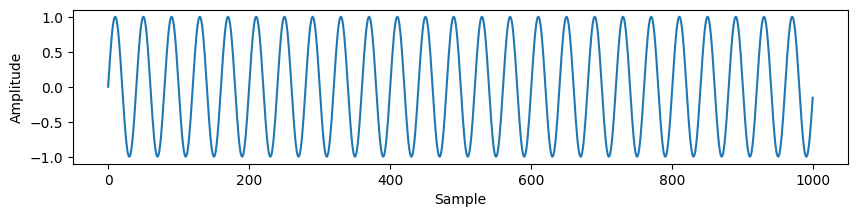

In [2]:
# Generate, visualise and play a sound with custom frequency and duration

def make_audio(duration=2, sampling_rate=16000, frequency=100, print=True):
    # Create the samples
    N = duration*sampling_rate # number of samples for given duration
    n = np.arange(N) # sample indices
    audio=np.sin(2*np.pi*(frequency/sampling_rate)*n) # generate sine wave

    # Visualise the first thousand samples
    if print:
        plt.figure(figsize=(10, 2))
        plt.plot(n[:1000], audio[:1000])
        plt.xlabel("Sample")
        plt.ylabel("Amplitude")
        plt.show()

    # Play the sound
    return audio

# Customise the sound's parameters
duration = 2 # duration in seconds
sampling_rate = 16000 # sampling rate
frequency = 400 # frequency in Hertz (Hz)


# Generate, visualise and play the sound
audio = make_audio(duration=duration, sampling_rate=sampling_rate, frequency=frequency, print=True)
ipyd.Audio(rate=sampling_rate, data=audio)

The FFT is an algorithm that breaks down a signal into its constituent frequencies. If we apply the FFT to our audio signal, we will see its frequency components. For applying the FFT, we need to specify an audio and its sampling rate.

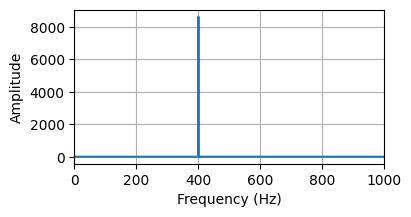

In [3]:
def apply_fft(audio, sampling_rate=16000, logscale=False):
    # Apply FFT
    N = len(audio)
    w = np.hamming(N)
    audioFFT = np.fft.fft(audio*w)
    
    # Plot spectrum
    plt.figure(figsize=(4, 2))
    if logscale:
        plt.plot(np.linspace(0, sampling_rate*(N - 1)/N, N), np.log(np.abs(audioFFT)))
    else:
        plt.plot(np.linspace(0, sampling_rate*(N - 1)/N, N), np.abs(audioFFT))
    plt.grid(True)
    plt.grid(True)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.xlim(0, 1000)
    
    return plt

plt = apply_fft(audio=audio, sampling_rate=sampling_rate)
plt.show()

### Illustration of the FFT

In this section, we walk through a few examples, illustrating the nature of audio signals. First, we synthesise a A minor chord, which consists of the notes A (110 Hz, 220 Hz, 440 Hz etc. ), C (130.81 Hz, 261.63 Hz, 523.25 Hz, etc.), and E (164.81 Hz, 329.63 Hz, 659.25  Hz etc.). There are multiple frequencies for each note because notes can be playes in different octaves.

#### Synthesised A minor chord

In [4]:
A_FQ = [110, 220, 440]
C_FQ = [130, 261, 523]
E_FQ = [164, 330, 659]

octave = 1

# synthesise the fate motif
A = make_audio(duration=2, sampling_rate=sampling_rate, frequency=A_FQ[octave], print=False)
C = make_audio(duration=2, sampling_rate=sampling_rate, frequency=C_FQ[octave], print=False)
E = make_audio(duration=2, sampling_rate=sampling_rate, frequency=E_FQ[octave], print=False)
AminorSynth = A + C + E
ipyd.Audio(rate=sampling_rate, data=AminorSynth)

The FFT helps us to break down the frequency content of the A minor chord.

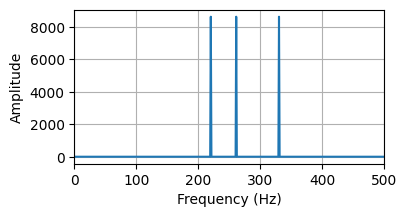

In [5]:
# investigate the fate motifs frequency components.
plt = apply_fft(audio=AminorSynth, sampling_rate=sampling_rate)
plt.xlim(0, 500)
plt.show()

#### Natural A minor chord

However, natural sound is more complex than pure tones for a number of reasons:

1. In the context of music, instruments produce rich harmonic content. That is, a single note on an instrument produces a sine wave at its fundamental frequency (e.g., 110 Hz for A), but also at its overtones (e.g., 220 Hz, 440 Hz).
2. The environment produces reflections and filtering effects of specific frequencies.
3. Natural sound have transient onsets, vibrato and natural fluctiations, which are especially important for speech sounds

In [6]:
# load and play a recording from the New York Philharmonic Orchestra
naturalAminor, srNatural = librosa.load("./data/guitar_chord_a_minor.wav", sr=None)

# only keep audio from second 3 to 5
naturalAminor = naturalAminor[3*srNatural:5*srNatural]
ipyd.Audio(data=naturalAminor, rate=srNatural)

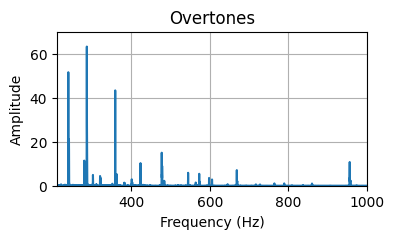

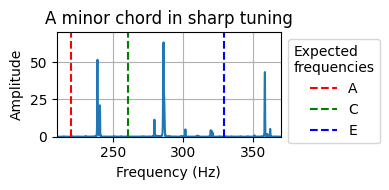

In [7]:
# visualise overtones
plt = apply_fft(audio=naturalAminor, sampling_rate=sampling_rate)
plt.xlim(210, 1000)
plt.ylim(0, 70)
plt.title("Overtones")
plt.show()

# visualise human tuning (this guitar is in sharp tuning so that the observed frequencies are higher than the expected ones)
plt = apply_fft(audio=naturalAminor, sampling_rate=sampling_rate)
plt.xlim(210, 370)
plt.ylim(0, 70)
plt.title("A minor chord in sharp tuning")
plt.axvline(x=220, color='r', linestyle='--', label="A")
plt.axvline(x=261, color='g', linestyle='--', label="C")
plt.axvline(x=329.63, color='b', linestyle='--', label="E")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Expected\nfrequencies")

# Display the plot
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

#### Speech sounds

Speech consists of a series of sounds that are combined to form words. Next, we consider a vowel, which is called Schwa. Schwa is common vowel sound in German and English. It can be found in German words such as *b**e**reit* (ready) and *viel**e*** (many) or English words such as ***a**bout*.

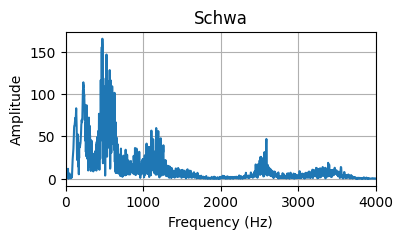

In [8]:
schwa, srSchwa= librosa.load("./data/Schwa.ogg.mp3", sr=None)

plt = apply_fft(audio=schwa, sampling_rate=srSchwa)
plt.xlim(0,4000)
plt.title("Schwa")
plt.show()

ipyd.Audio(data=schwa, rate=srSchwa)

When creating our acoustic features for training an ASR model, we make use of our knowledge about human perception. Two aspectes of human perception are especially relevant for ASR engineers:

1. The full range of human hearing is from 20 Hz to 20,000 Hz but humans hear most accurately and sensitively in a narrower range from ~ 500 Hz to 4,000 Hz. Consequently, frequencies higher than 4,000 Hz can be ignored.
2. Humans are more sensitive to changes of soft sounds (low amplitudes) than to changes of loud sounds (high amplitude). For instance, we perceive two cars driving by louder than one car driving by, but we cannot hear a difference between 100 or 102 cars driving by.

Because of how humans perceive sound, we cut off our signal at 4,000 Hz (higher frequencies are irrelevant) and we log-transform the frequency components (emphasising changes on low amplitude areas).

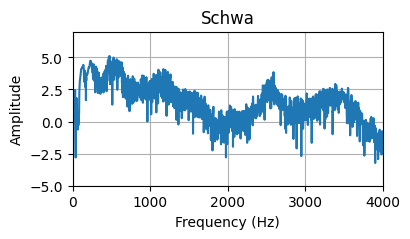

In [9]:
plt = apply_fft(audio=schwa, sampling_rate=srSchwa, logscale=True) # note that logscale has been set to True
plt.xlim(0,4000)
plt.ylim(-5, 7)
plt.title("Schwa")
plt.show()

A closer inspection of more speech sounds reveals that each sound has its own characteristic frequency spectrum.

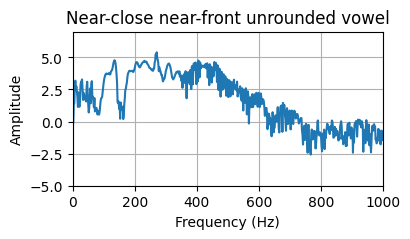

In [10]:
vowel1, srVowel1= librosa.load("./data/Near-close_near-front_unrounded_vowel.ogg.mp3", sr=None)

plt = apply_fft(audio=vowel1, sampling_rate=srVowel1, logscale=True)
plt.ylim(-5, 7)
plt.title("Near-close near-front unrounded vowel")
plt.show()

ipyd.Audio(data=vowel1, rate=srVowel1)

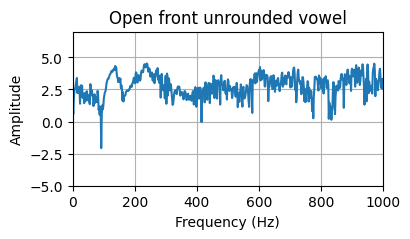

In [11]:
vowel2, srVowel2 = librosa.load("./data/Open_front_unrounded_vowel.ogg.mp3", sr=None)

plt = apply_fft(audio=vowel2, sampling_rate=srVowel2, logscale=True)
plt.ylim(-5, 7)
plt.title("Open front unrounded vowel")
plt.show()

ipyd.Audio(data=vowel2, rate=srVowel2)

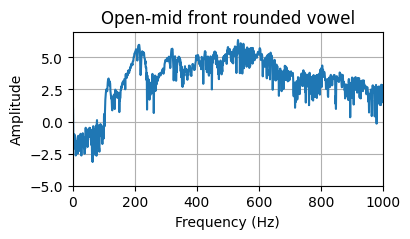

In [12]:
vowel3, srVowel3 = librosa.load("./data/Open-mid_front_rounded_vowel.ogg.mp3", sr=None)

plt = apply_fft(audio=vowel3, sampling_rate=srVowel3, logscale=True)
plt.ylim(-5, 7)
plt.title("Open-mid front rounded vowel")
plt.show()

ipyd.Audio(data=vowel3, rate=srVowel3)

#### From sounds to words

While vowel sounds may be accurately discriminated based on their frequency spectra, even when analysed as a whole, longer sequences of speech (e.g., word, sentences) should be analysed sequentially. For instance, our features should not only capture that an audio sequence consists of frequency spectra corresponding to *a*, *e*, *l*, and *p*, but they should also capture information about order. Otherwise, it would not be possible to discriminate between *leap*, *pale*, *peal*, and *plea*.

### Short-time Fourier transform (STFT)

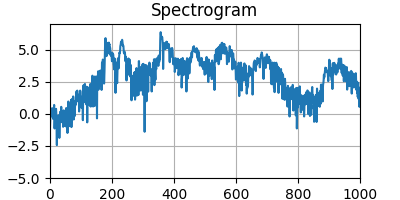

In [26]:
spectrogram, srSpectrogram = librosa.load("./data/spectrogram.wav", sr=None)

plt = apply_fft(audio=spectrogram, sampling_rate=srSpectrogram, logscale=True)
plt.ylim(-5, 7)
plt.title("Spectrogram")
plt.show()

ipyd.Audio(data=spectrogram, rate=srSpectrogram)

In [14]:
# function for creating a 3D spectrogram
def plot_spectrogram(audio, sampling_rate, log_scale=True, hop_length=50, window_size=50):

    # initialise the first window
    window = [0, window_size]
    while window[1] < len(audio):

        # Create a window of the audio signal
        audio_window = audio[window[0]:window[1]]
    
        # Apply FFT
        w = np.hamming(window_size)
        if log_scale:
            windowFFT = np.log(np.abs(np.fft.fft(audio_window*w)))
        else:
            windowFFT = np.abs(np.fft.fft(audio_window*w))

        # store the FFT result
        if window[0] == 0:
            spectrogram = windowFFT
        else:
            spectrogram = np.vstack((spectrogram, windowFFT))
        window[0] += hop_length
        window[1] += hop_length

    # return the spectrogram
    return spectrogram

Text(0, 0.5, 'Amplitude')

<Figure size 1000x600 with 0 Axes>

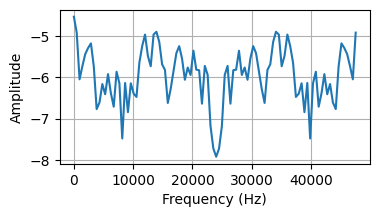

<Figure size 793x478 with 0 Axes>

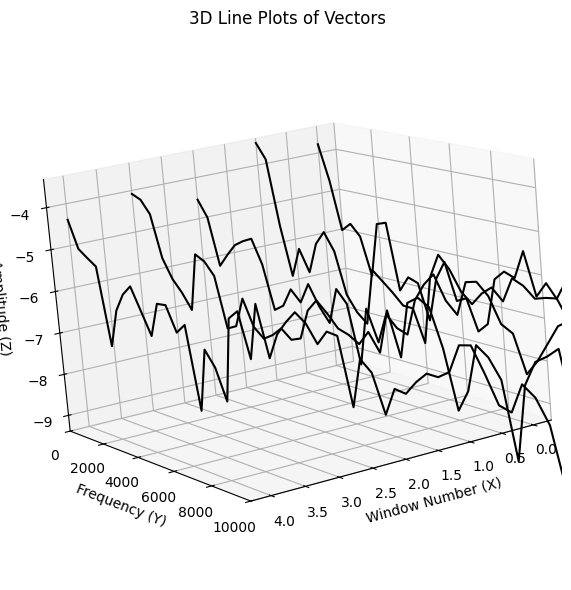

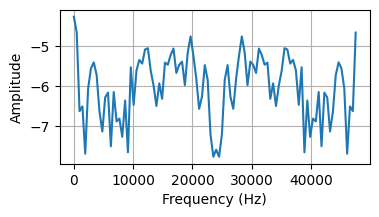

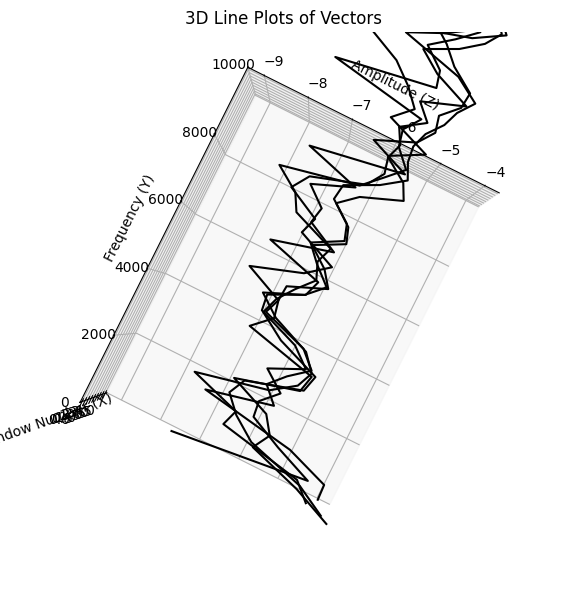

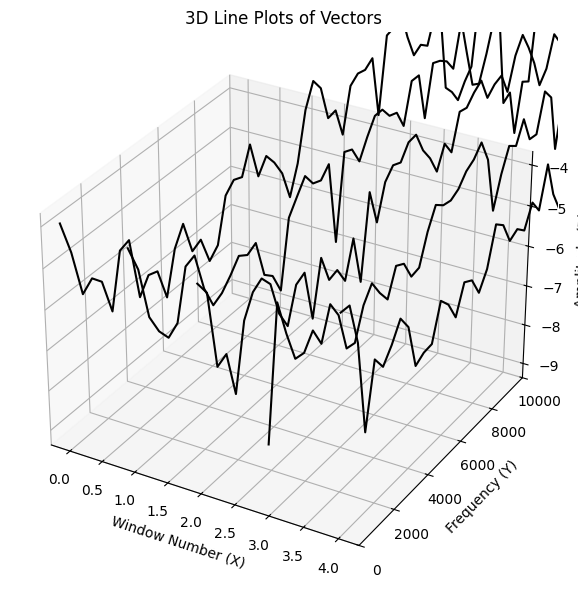

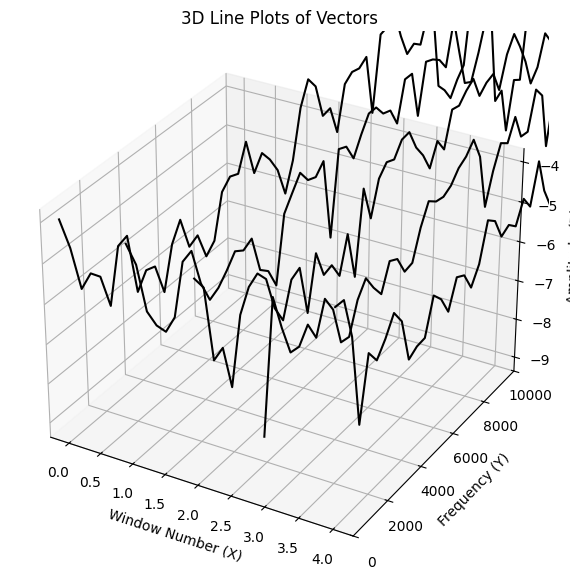

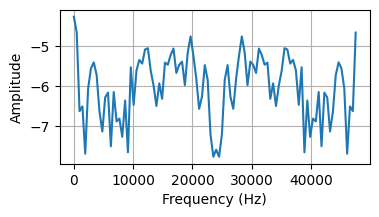

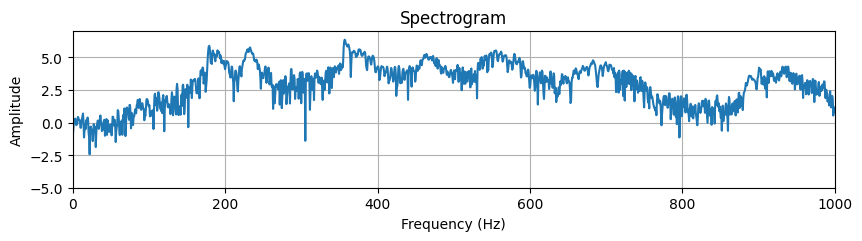

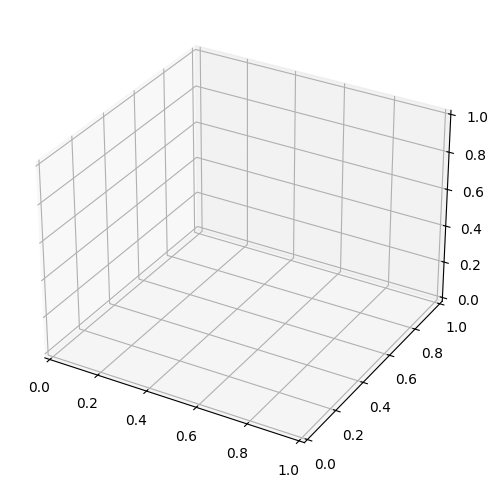

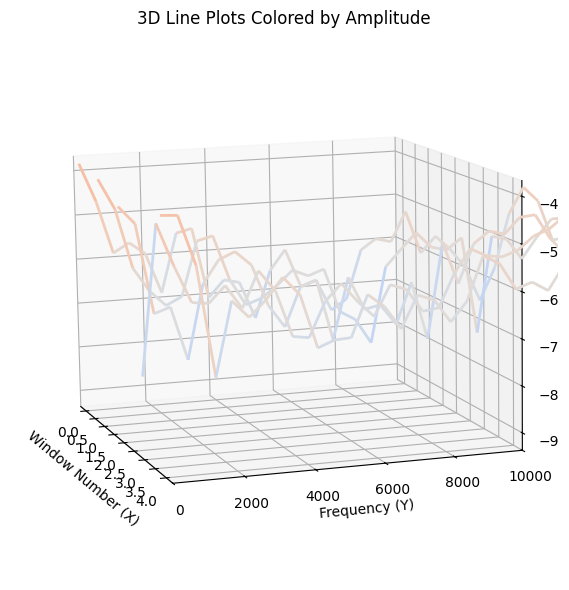

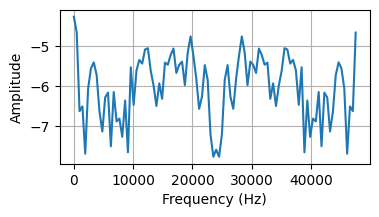

In [32]:
%matplotlib inline

window_length = 100
hop_length = 20

test = plot_spectrogram(spectrogram, sampling_rate=srSpectrogram, log_scale=True, hop_length=hop_length, window_size=window_length)

plt.figure(figsize=(4, 2))
plt.plot(np.linspace(0, srSpectrogram*(window_length - 1)/window_length, window_length), test[2])
plt.grid(True)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')

In [23]:
%matplotlib inline

In [29]:
# Flatten the list of vectors into a 1D array
flat = np.concatenate(test)

# Find min and max
lowest = np.min(flat)
highest = np.max(flat)

/tmp/ipykernel_35156/1423875592.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('coolwarm')  # blue (cold) to red (warm)


ValueError: array([[0.96377182, 0.74908551, 0.64942004, 1.        ],
       [0.9455403 , 0.79860574, 0.72310542, 1.        ],
       [0.89588177, 0.84990606, 0.82349908, 1.        ],
       [0.90615413, 0.84209107, 0.80615059, 1.        ],
       [0.89181689, 0.85197328, 0.82908527, 1.        ],
       [0.83935144, 0.86116683, 0.89449376, 1.        ],
       [0.91276506, 0.83668189, 0.79451211, 1.        ],
       [0.91607053, 0.83397731, 0.78869287, 1.        ],
       [0.82678432, 0.85820536, 0.90695264, 1.        ],
       [0.85137164, 0.86312531, 0.88106382, 1.        ],
       [0.84335817, 0.86181965, 0.89001712, 1.        ],
       [0.79139229, 0.84675021, 0.93664093, 1.        ],
       [0.8593851 , 0.86443097, 0.87211053, 1.        ],
       [0.88368714, 0.85610772, 0.84025767, 1.        ],
       [0.83534471, 0.860514  , 0.89897041, 1.        ],
       [0.83935144, 0.86116683, 0.89449376, 1.        ],
       [0.79606387, 0.84869321, 0.93347147, 1.        ],
       [0.80932867, 0.852974  , 0.92232259, 1.        ],
       [0.87555739, 0.86024216, 0.85143007, 1.        ],
       [0.89181689, 0.85197328, 0.82908527, 1.        ],
       [0.88368714, 0.85610772, 0.84025767, 1.        ],
       [0.91937599, 0.83127272, 0.78287363, 1.        ],
       [0.86742764, 0.8643766 , 0.86260246, 1.        ],
       [0.88775202, 0.8540405 , 0.83467147, 1.        ],
       [0.86742764, 0.8643766 , 0.86260246, 1.        ],
       [0.84335817, 0.86181965, 0.89001712, 1.        ],
       [0.79139229, 0.84675021, 0.93664093, 1.        ],
       [0.83935144, 0.86116683, 0.89449376, 1.        ],
       [0.9094596 , 0.83938648, 0.80033135, 1.        ],
       [0.93322118, 0.81555685, 0.75315143, 1.        ],
       [0.91937599, 0.83127272, 0.78287363, 1.        ],
       [0.87149251, 0.86230938, 0.85701626, 1.        ],
       [0.87555739, 0.86024216, 0.85143007, 1.        ],
       [0.82678432, 0.85820536, 0.90695264, 1.        ],
       [0.89588177, 0.84990606, 0.82349908, 1.        ],
       [0.90284867, 0.84479565, 0.81196983, 1.        ],
       [0.89954321, 0.84750024, 0.81778907, 1.        ],
       [0.9094596 , 0.83938648, 0.80033135, 1.        ],
       [0.80932867, 0.852974  , 0.92232259, 1.        ],
       [0.92268145, 0.82856814, 0.77705439, 1.        ],
       [0.92556342, 0.8255173 , 0.77113631, 1.        ],
       [0.93577377, 0.8122367 , 0.74715647, 1.        ],
       [0.89954321, 0.84750024, 0.81778907, 1.        ],
       [0.86339183, 0.8650838 , 0.86763388, 1.        ],
       [0.87149251, 0.86230938, 0.85701626, 1.        ],
       [0.86339183, 0.8650838 , 0.86763388, 1.        ],
       [0.90284867, 0.84479565, 0.81196983, 1.        ],
       [0.88368714, 0.85610772, 0.84025767, 1.        ],
       [0.75853883, 0.83278659, 0.95840785, 1.        ],
       [0.73882599, 0.82257162, 0.96826106, 1.        ],
       [0.71385249, 0.80885714, 0.97938649, 1.        ],
       [0.73882599, 0.82257162, 0.96826106, 1.        ],
       [0.75853883, 0.83278659, 0.95840785, 1.        ],
       [0.88368714, 0.85610772, 0.84025767, 1.        ],
       [0.90284867, 0.84479565, 0.81196983, 1.        ],
       [0.86339183, 0.8650838 , 0.86763388, 1.        ],
       [0.87149251, 0.86230938, 0.85701626, 1.        ],
       [0.86339183, 0.8650838 , 0.86763388, 1.        ],
       [0.89954321, 0.84750024, 0.81778907, 1.        ],
       [0.93577377, 0.8122367 , 0.74715647, 1.        ],
       [0.92556342, 0.8255173 , 0.77113631, 1.        ],
       [0.92268145, 0.82856814, 0.77705439, 1.        ],
       [0.80932867, 0.852974  , 0.92232259, 1.        ],
       [0.9094596 , 0.83938648, 0.80033135, 1.        ],
       [0.89954321, 0.84750024, 0.81778907, 1.        ],
       [0.90284867, 0.84479565, 0.81196983, 1.        ],
       [0.89588177, 0.84990606, 0.82349908, 1.        ],
       [0.82678432, 0.85820536, 0.90695264, 1.        ],
       [0.87555739, 0.86024216, 0.85143007, 1.        ],
       [0.87149251, 0.86230938, 0.85701626, 1.        ],
       [0.91937599, 0.83127272, 0.78287363, 1.        ],
       [0.93322118, 0.81555685, 0.75315143, 1.        ],
       [0.9094596 , 0.83938648, 0.80033135, 1.        ],
       [0.83935144, 0.86116683, 0.89449376, 1.        ],
       [0.79139229, 0.84675021, 0.93664093, 1.        ],
       [0.84335817, 0.86181965, 0.89001712, 1.        ],
       [0.86742764, 0.8643766 , 0.86260246, 1.        ],
       [0.88775202, 0.8540405 , 0.83467147, 1.        ],
       [0.86742764, 0.8643766 , 0.86260246, 1.        ],
       [0.91937599, 0.83127272, 0.78287363, 1.        ],
       [0.88368714, 0.85610772, 0.84025767, 1.        ],
       [0.89181689, 0.85197328, 0.82908527, 1.        ],
       [0.87555739, 0.86024216, 0.85143007, 1.        ],
       [0.80932867, 0.852974  , 0.92232259, 1.        ],
       [0.79606387, 0.84869321, 0.93347147, 1.        ],
       [0.83935144, 0.86116683, 0.89449376, 1.        ],
       [0.83534471, 0.860514  , 0.89897041, 1.        ],
       [0.88368714, 0.85610772, 0.84025767, 1.        ],
       [0.8593851 , 0.86443097, 0.87211053, 1.        ],
       [0.79139229, 0.84675021, 0.93664093, 1.        ],
       [0.84335817, 0.86181965, 0.89001712, 1.        ],
       [0.85137164, 0.86312531, 0.88106382, 1.        ],
       [0.82678432, 0.85820536, 0.90695264, 1.        ],
       [0.91607053, 0.83397731, 0.78869287, 1.        ],
       [0.91276506, 0.83668189, 0.79451211, 1.        ],
       [0.83935144, 0.86116683, 0.89449376, 1.        ],
       [0.89181689, 0.85197328, 0.82908527, 1.        ],
       [0.90615413, 0.84209107, 0.80615059, 1.        ],
       [0.89588177, 0.84990606, 0.82349908, 1.        ],
       [0.9455403 , 0.79860574, 0.72310542, 1.        ]]) is not a valid value for color: supported inputs are (r, g, b) and (r, g, b, a) 0-1 float tuples; '#rrggbb', '#rrggbbaa', '#rgb', '#rgba' strings; named color strings; string reprs of 0-1 floats for grayscale values; 'C0', 'C1', ... strings for colors of the color cycle; and pairs combining one of the above with an alpha value

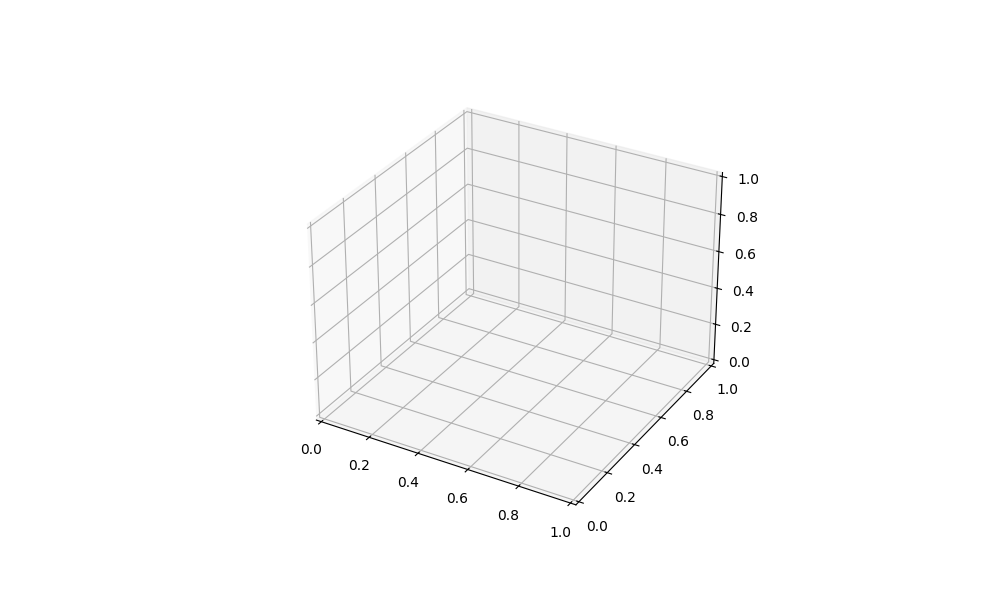

In [30]:
# for creating a responsive plot
%matplotlib widget

# importing required libraries
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize

# Create colormap from blue to red
cmap = cm.get_cmap('coolwarm')  # blue (cold) to red (warm)
norm = Normalize(vmin=lowest, vmax=highest)

# Prepare 3D figure
fig = plt.figure(figsize=(10, 6))
#ax = Axes3D(fig)
ax = fig.add_subplot(111, projection='3d')

# Plot each vector
for idx, vec in enumerate(test[0:5]):
    x = idx
    y = np.linspace(0, srSpectrogram*(window_length - 1)/window_length, window_length)
    z = test[idx]
    color = cmap(norm(z))  # map z to a color
    ax.plot(x, y, z, color=color)
    ax.set_ylim(0, 10000)
    

# Labels and legend
ax.set_xlabel('Window Number (X)')
ax.set_ylabel('Frequency (Y)')
ax.set_zlabel('Amplitude (Z)')
ax.set_title('3D Line Plots of Vectors')

plt.tight_layout()
plt.show()


/tmp/ipykernel_35156/961407856.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('coolwarm')  # blue to red


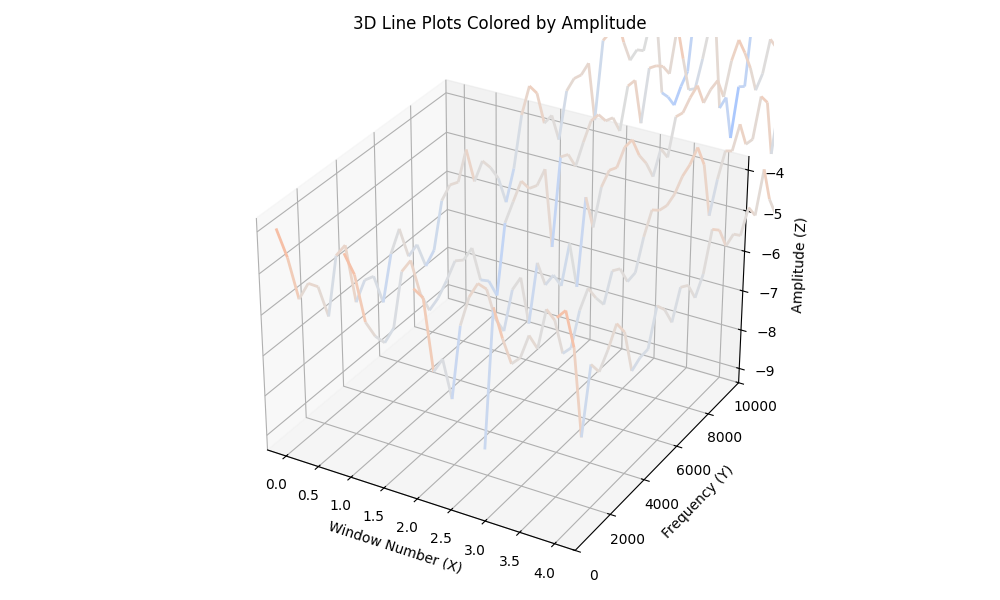

In [ ]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib import cm

# Create colormap and normalization
cmap = cm.get_cmap('coolwarm')  # blue to red
norm = Normalize(vmin=lowest, vmax=highest)

# Set up 3D plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Loop through vectors
for idx, vec in enumerate(test[0:5]):
    y = np.linspace(0, srSpectrogram * (window_length - 1) / window_length, window_length)
    x = np.full_like(y, idx)  # Constant x value for each vector
    z = vec

    # Create segments
    points = np.array([x, y, z]).T.reshape(-1, 1, 3)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Map colors per segment using z values
    values = z[:-1]  # one color per segment (length-1)
    colors = cmap(norm(values))

    # Create and add line collection
    lc = Line3DCollection(segments, colors=colors, linewidth=2)
    ax.add_collection3d(lc)

# Axes labels and limits
ax.set_ylim(0, 10000)
ax.set_xlabel('Window Number (X)')
ax.set_ylabel('Frequency (Y)')
ax.set_zlabel('Amplitude (Z)')
ax.set_title('3D Line Plots Colored by Amplitude')

plt.tight_layout()
plt.show()

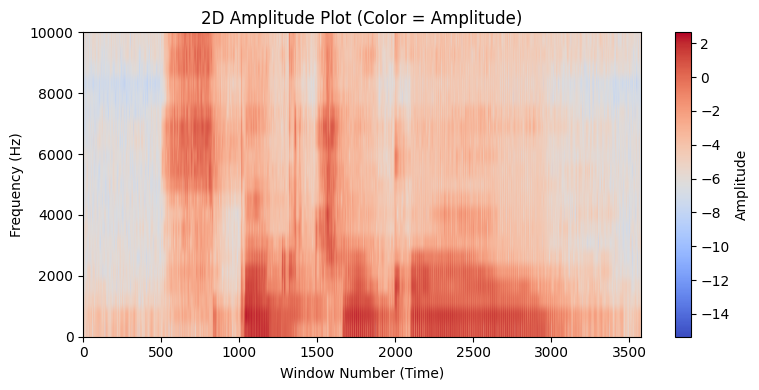

In [35]:
# Convert your list of vectors into a 2D array
# Each row = one time window, each column = frequency bin
amplitudes = np.array(test)  # shape: (time, freq)

plt.figure(figsize=(8, 4))
plt.imshow(
    amplitudes.T,                # transpose so freq on y-axis
    aspect='auto',
    origin='lower',
    cmap='coolwarm',
    extent=[0, amplitudes.shape[0], 0, srSpectrogram * (window_length - 1) / window_length]
)
plt.ylim(0, 10000)
plt.xlabel('Window Number (Time)')
plt.ylabel('Frequency (Hz)')
plt.title('2D Amplitude Plot (Color = Amplitude)')
plt.colorbar(label='Amplitude')
plt.tight_layout()
plt.show()